# NYPD Stop & Frisk Data Analysis Project
#### Malik Ouda, Vee Lee Koh, Clay Roberts, Noah Placke
---
## Stop, Question and Frisk Data
This dataset is provided by the New York Police Department and contains information about the stop, question, and frisk policy implemented by the NYPD. It is a controversial and highly criticized policy in which a police officer suspecting someone of wrongdoing is able to stop them, question them, and search them for a weapon. The policy has been highly criticized for being a form of racial profiling.

The full dataset contains records of this policy dating from 2003 to 2019. It includes a record for each stop made, with information about the time of the stop, the location of the stop, information about the officer, the suspect, and other various features.

The data that will be used in this analysis is from the year 2011, which saw the highest number of stops of any year. This data will be used to attempt to **predict whether someone will get frisked** based on the circumstances of the stop and the features of the individual suspect.

We would like to determine what features are most signifcant in determining whether a suspect gets frisked by an officer. Our results could be used to ensure fair and unbiased policing are practiced by the NYPD. This issue is especially vital to reduce police brutality and racial profiling.  

---
### References
- <a href='https://www.nyclu.org/en/stop-and-frisk-data'> NY Civil Liberty Union Stop and Frisk statistics </a>
- <a href='https://www1.nyc.gov/site/nypd/stats/reports-analysis/stopfrisk.page'> NYPD Stop and Frisk Data </a>


## Load 2011 Stop & Frisk Dataset

In [1]:
# Import Statements
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Load the comma delimited data file
path = "./2011.csv"
initial_data = pd.read_csv(path, encoding='latin-1', low_memory=False) 
initial_data.head()

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypcm,linecm,detailcm
0,2011,102,185,1012011,0,A,O,P,1,BURGLARY,...,,102,B,,,1030708,194185,CM,1,14
1,2011,115,50,1012011,5,A,O,P,1,FEL,...,,115,I,,,1021302,213563,CM,1,85
2,2011,100,4,1012011,7,1,O,H,1,CPW,...,,100,B,4,34,1037668,153549,CM,1,20
3,2011,100,3,1012011,7,1,O,H,1,CPW,...,,100,B,4,34,1037668,153549,CM,1,20
4,2011,100,1,1012011,7,1,O,H,1,CPW,...,,100,B,4,34,1037668,153549,CM,1,20


In [3]:
# Check size of dataset
initial_data.shape

(685724, 112)

In [4]:
# Check for presence of duplicate rows before filtering to relevant features
initial_data[initial_data.duplicated()].shape

(0, 112)

## Data Preprocessing

Cleaning the data and prepping it

In [5]:
# Extract relevant features (predictor and response) that will be utilized for analysis and remove those that will result in data leakage
# Precint (pct) is retained to clean city feature, but will be removed later on due to difficulty in binning them into separate pricints

# snf_data_pre = 'stop and frisk' data before preliminary processing
# Predictor features include description of suspect, officer behaviour and circumstances of the stop
# Response feature is whether the suspect was frisked
snf_data_pre = initial_data[['sex','race','age','ht_feet','ht_inch','weight','haircolr','eyecolor','build',
                            'city','pct','timestop','inout','trhsloc','typeofid','othpers',
                            'explnstp','offunif','officrid','offverb','offshld',
                            'ac_rept','ac_proxm','ac_evasv','ac_assoc','ac_cgdir','ac_incid','ac_time','ac_stsnd',
                            'frisked']].copy()

In [6]:
# Numeric features
snf_data_pre.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,685724.0,29.398764,37.221556,0.0,19.0,24.0,34.0,999.0
ht_feet,685724.0,5.179049,0.394506,3.0,5.0,5.0,5.0,7.0
ht_inch,685724.0,6.415804,3.342623,0.0,4.0,7.0,9.0,11.0
weight,685724.0,169.323824,37.683693,0.0,150.0,165.0,180.0,999.0
pct,685724.0,67.375982,32.736376,1.0,42.0,71.0,101.0,123.0
timestop,685724.0,1435.877044,727.141924,0.0,1034.0,1630.0,2028.0,2359.0


In [7]:
### Calculate total height of individuals in inches by combining ht_feet and ht_inch

# Create new column combining feet and inches into one number
snf_data_pre['ht_inch'] = (snf_data_pre['ht_feet'] * 12) + snf_data_pre['ht_inch']

# Delete feet column 
del snf_data_pre['ht_feet']

# Rename ht_inch to height
snf_data_pre.rename(columns={'ht_inch': 'height'}, inplace=True)

snf_data_pre.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,685724.0,29.398764,37.221556,0.0,19.0,24.0,34.0,999.0
height,685724.0,68.564389,3.181265,36.0,67.0,69.0,71.0,95.0
weight,685724.0,169.323824,37.683693,0.0,150.0,165.0,180.0,999.0
pct,685724.0,67.375982,32.736376,1.0,42.0,71.0,101.0,123.0
timestop,685724.0,1435.877044,727.141924,0.0,1034.0,1630.0,2028.0,2359.0


In [8]:
# Get data types
snf_data_pre.dtypes

sex         object
race        object
age          int64
height       int64
weight       int64
haircolr    object
eyecolor    object
build       object
city        object
pct          int64
timestop     int64
inout       object
trhsloc     object
typeofid    object
othpers     object
explnstp    object
offunif     object
officrid    object
offverb     object
offshld     object
ac_rept     object
ac_proxm    object
ac_evasv    object
ac_assoc    object
ac_cgdir    object
ac_incid    object
ac_time     object
ac_stsnd    object
frisked     object
dtype: object

In [9]:
# Get list of column names which are of type string (categorical) 
str_cols = snf_data_pre.select_dtypes(['object']).columns
str_cols

Index(['sex', 'race', 'haircolr', 'eyecolor', 'build', 'city', 'inout',
       'trhsloc', 'typeofid', 'othpers', 'explnstp', 'offunif', 'officrid',
       'offverb', 'offshld', 'ac_rept', 'ac_proxm', 'ac_evasv', 'ac_assoc',
       'ac_cgdir', 'ac_incid', 'ac_time', 'ac_stsnd', 'frisked'],
      dtype='object')

In [10]:
# String features 
snf_data_pre[str_cols].describe()
# There are a number of features with missing values (city, officrid, offverb, offshld)

,sex,race,haircolr,eyecolor,build,city,inout,trhsloc,typeofid,othpers,...,offshld,ac_rept,ac_proxm,ac_evasv,ac_assoc,ac_cgdir,ac_incid,ac_time,ac_stsnd,frisked
count,685724,685724,685724,685724,685724,685724,685724,685724,685724,685724,...,685724,685724,685724,685724,685724,685724,685724,685724,685724,685724
unique,3,8,11,13,5,6,2,3,4,2,...,2,2,2,2,2,2,2,2,2,2
top,M,B,BK,BR,M,BROOKLYN,O,P,P,N,...,,N,N,N,N,N,Y,N,N,Y
freq,626830,350743,519671,615932,402968,228324,545779,544854,368749,537590,...,512650,607202,539509,553879,657165,519347,407523,398181,668900,381704


### Handling missing values

In [11]:
# Create deep copy of dataframe in case there's need to revert to original dataframe
snf_data_toclean = snf_data_pre.copy()
snf_data_toclean.shape

(685724, 29)

In [12]:
# Replace empty values of parameters with Nan
snf_data_toclean.replace(to_replace=' ', value=np.NaN, inplace=True)

In [13]:
# Count number of empty values
snf_data_toclean.isnull().sum()

sex              0
race             0
age              0
height           0
weight           0
haircolr         0
eyecolor         0
build            0
city            38
pct              0
timestop         0
inout            0
trhsloc          0
typeofid         0
othpers          0
explnstp         0
offunif          0
officrid    677711
offverb     548624
offshld     512650
ac_rept          0
ac_proxm         0
ac_evasv         0
ac_assoc         0
ac_cgdir         0
ac_incid         0
ac_time          0
ac_stsnd         0
frisked          0
dtype: int64

Each precint has a corresponding city (a city can have multiple precints). Hence, the missing city values can be imputed using their corresponding precint. 

Reference: [New York City Precint Information](https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page)

In [14]:
# View pct (precints) of missing city data
snf_data_toclean.loc[snf_data_toclean['city'].isnull()]['pct'].unique()

array([ 18,  23,  33,  34,  70,  73,  75,  77,  79,  88, 115, 120])

In [15]:
# Impute missing city values using precint data

for i in [1, 5, 6, 7, 9, 10, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='MANHATTAN'

for i in [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='BRONX'

for i in [60,61,62,63,66,67,68,69,70,71,72,73,75,76,77,78,79,81,83,84,88,90,94]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='BROOKLYN'

for i in [100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='QUEENS'

for i in [120,121,122,123]:
  snf_data_toclean.loc[snf_data_toclean['pct']==i, 'city']='STATEN IS'

In [16]:
# Check all city values have been imputed correctly (no null values)
snf_data_toclean.isnull().sum()['city']

0

In [17]:
# Drop precint column as no longer needed
snf_data_toclean.drop(labels='pct', axis=1, inplace=True)

# Check if pct removed
'pct' in snf_data_toclean 

False

In [18]:
# View quantity of unique values in officrid, offverb and offshld  
print(snf_data_toclean['officrid'].value_counts())
print(snf_data_toclean['offverb'].value_counts())
print(snf_data_toclean['offshld'].value_counts())

I    8013
Name: officrid, dtype: int64
V    137100
Name: offverb, dtype: int64
S    173074
Name: offshld, dtype: int64


Based on the dataset's documentation, the values of these features: 
* officrid (officer provided id)
* offverb (officer gave verbal statement)
* offshld (officer showed badge) 

are either a letter (meaning Yes), zero (No) or empty (not listed). 

As there isn't sufficient information to impute them, and deleting rows with missing values would result in loss of large portion of dataset, these columns will be dropped.


In [19]:
# Print shape of dataframe before dropping columns
print(snf_data_toclean.shape)
# Drop the 3 columns 
snf_data_toclean.drop(labels=['officrid', 'offverb', 'offshld'], axis=1, inplace=True)

(685724, 28)


In [20]:
# Check if columns removed correctly
snf_data_toclean.shape

(685724, 25)

### Handling unknown or inconsistent values 

In [21]:
# Get updated list of column names which are of type string (categorical) and integer
str_cols = snf_data_toclean.select_dtypes(['object']).columns
int_cols = snf_data_toclean.select_dtypes(['int64']).columns

In [22]:
# View unique values for each column
for i in str_cols:
  print (snf_data_toclean[i].value_counts())
  print()

M    626830
F     46784
Z     12110
Name: sex, dtype: int64

B    350743
Q    175302
W     61805
P     48438
A     23932
Z     16867
U      5740
I      2897
Name: race, dtype: int64

BK    519671
BR    129761
BA     11332
BL      8329
GY      6100
XX      3658
SP      3258
ZZ      2469
RA       932
DY       125
SN        89
Name: haircolr, dtype: int64

BR    615932
BK     43825
BL     11118
GR      4718
HA      4252
XX      2457
Z       2304
GY       747
DF       263
MA        83
VI        18
MC         5
P          2
Name: eyecolor, dtype: int64

M    402968
T    218469
H     55511
Z      6353
U      2423
Name: build, dtype: int64

BROOKLYN     228354
QUEENS       152681
MANHATTAN    140913
BRONX        135724
STATEN IS     28052
Name: city, dtype: int64

O    545779
I    139945
Name: inout, dtype: int64

P    544854
H     91015
T     49855
Name: trhsloc, dtype: int64

P    368749
V    292243
R     16468
O      8264
Name: typeofid, dtype: int64

N    537590
Y    148134
Name: othpers,

**List of unknown and inconsistent values**

* sex : Z (unknown) 
* race : U (unknown) & Z (other)
* haircolr : XX (unknown), ZZ (other) & RA (should be RD for red)
* eyecolor : XX (unknown), Z (other), MC (should be MA for maroon) & P (should be PK for pink)
* build : Z (unknown) 
  * U here means muscular, not unknown
* typeofid : O (other)

The rows with 'unknown' and 'other' values will be removed as we have no information as to what they represent, whereas the erroneous values will be replaced to ensure consistent values in our dataset.


In [23]:
# Replace all 'other' and 'unknown' values with NaN and drop those rows
snf_data_toclean = snf_data_toclean.replace(['Z', 'ZZ', 'XX'], np.NaN)
snf_data_toclean.dropna(inplace=True)

# Check if rows with NaN were removed
snf_data_toclean[snf_data_toclean.isna().any(axis=1)].shape

(0, 25)

In [24]:
# Remove rows with value 'O' in typeofid column
snf_data_toclean = snf_data_toclean[snf_data_toclean['typeofid']!='O']

# Check if rows removed
snf_data_toclean[snf_data_toclean['typeofid']=='O'].shape

(0, 25)

In [25]:
# Remove rows with value 'U' in race column
snf_data_toclean = snf_data_toclean[snf_data_toclean['race']!='U']

# Check if rows removed
snf_data_toclean[snf_data_toclean['race']=='U'].shape

(0, 25)

In [26]:
# Replace erroneous value on haircolor column
snf_data_toclean['haircolr'] = snf_data_toclean['haircolr'].replace({'RA': 'RD'})
snf_data_toclean['haircolr'].value_counts()

BK    489126
BR    121476
BA     10606
BL      7651
GY      5559
SP      2974
RD       856
DY       121
SN        78
Name: haircolr, dtype: int64

In [27]:
# Replace erroneous value on eyecolor column
snf_data_toclean['eyecolor'] = snf_data_toclean['eyecolor'].replace({'MC':'MA', 'P':'PK'})
snf_data_toclean['eyecolor'].value_counts()

BR    578298
BK     40484
BL     10253
GR      4385
HA      3987
GY       697
DF       252
MA        74
VI        15
PK         2
Name: eyecolor, dtype: int64

In [28]:
# Check unique values for each column
for i in str_cols:
  print (snf_data_toclean[i].value_counts())
  print()

M    594678
F     43769
Name: sex, dtype: int64

B    337784
Q    169020
W     59197
P     46410
A     23262
I      2774
Name: race, dtype: int64

BK    489126
BR    121476
BA     10606
BL      7651
GY      5559
SP      2974
RD       856
DY       121
SN        78
Name: haircolr, dtype: int64

BR    578298
BK     40484
BL     10253
GR      4385
HA      3987
GY       697
DF       252
MA        74
VI        15
PK         2
Name: eyecolor, dtype: int64

M    379602
T    204638
H     51975
U      2232
Name: build, dtype: int64

BROOKLYN     213258
QUEENS       144599
MANHATTAN    128796
BRONX        125334
STATEN IS     26460
Name: city, dtype: int64

O    509097
I    129350
Name: inout, dtype: int64

P    506256
H     86190
T     46001
Name: trhsloc, dtype: int64

P    348336
V    275159
R     14952
Name: typeofid, dtype: int64

N    499859
Y    138588
Name: othpers, dtype: int64

Y    637935
N       512
Name: explnstp, dtype: int64

Y    471622
N    166825
Name: offunif, dtype: int64

N  

## Data Exploration

Explore and visualize data to gain understanding of data


In [29]:
# Create deep copy of processed dataset
snf_data_exp = snf_data_toclean.copy()
snf_data_exp.shape

(638447, 25)

In [30]:
# View dataframe
snf_data_exp.head()

,sex,race,age,height,weight,haircolr,eyecolor,build,city,timestop,...,offunif,ac_rept,ac_proxm,ac_evasv,ac_assoc,ac_cgdir,ac_incid,ac_time,ac_stsnd,frisked
0,M,A,21,68,182,BK,BR,M,QUEENS,0,...,N,N,N,N,N,N,Y,Y,N,Y
1,M,B,15,66,140,BK,BR,M,QUEENS,5,...,N,N,N,N,N,N,Y,N,N,Y
2,M,B,17,67,130,BK,BR,T,QUEENS,7,...,Y,N,Y,N,N,Y,N,Y,N,Y
3,M,B,17,67,130,BK,BR,T,QUEENS,7,...,Y,N,Y,N,N,Y,N,Y,N,Y
4,M,B,20,75,185,BK,BR,M,QUEENS,7,...,Y,N,Y,Y,N,Y,N,Y,N,Y


In [31]:
# View distribution of numerical data
snf_data_exp[int_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,638447.0,29.179915,35.339250,0.0,19.0,24.0,34.0,999.0
height,638447.0,68.572174,3.143190,36.0,67.0,69.0,71.0,95.0
weight,638447.0,169.075388,33.913560,0.0,150.0,165.0,180.0,999.0
timestop,638447.0,1437.847773,727.732732,0.0,1035.0,1630.0,2030.0,2359.0


### Explore continuous attributes

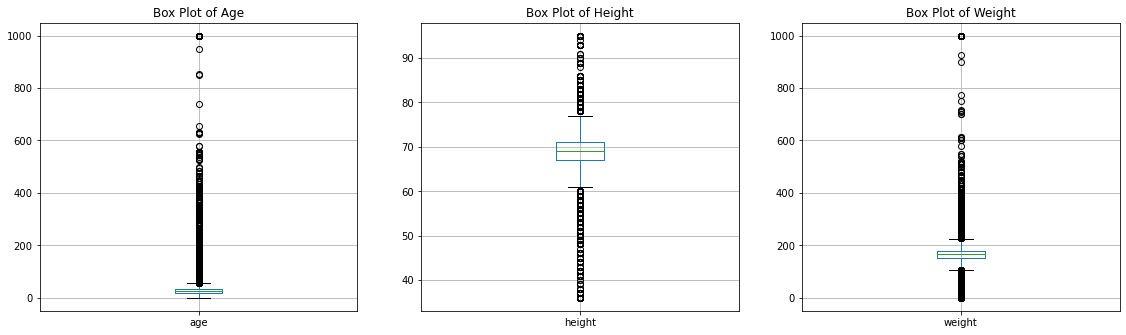

In [32]:
# Visualize distribution of ages, heights and weights using box plots
plt.subplot(131)
snf_data_exp.boxplot('age')
plt.title('Box Plot of Age')

plt.subplot(132)
snf_data_exp.boxplot('height')
plt.title('Box Plot of Height')

plt.subplot(133)
snf_data_exp.boxplot('weight')
plt.title('Box Plot of Weight')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1, wspace=0.2, hspace=0.2)

In [33]:
# Calculate upper and lower bounds of age, height and weight
print("Upper and Lower bounds")
for col in ['age', 'height', 'weight']:
    q1, q3 = np.percentile(snf_data_exp[col], [25,75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    print(col, lower_bound, upper_bound)

Upper and Lower bounds
age -3.5 56.5
height 61.0 77.0
weight 105.0 225.0


There exists erroneuous data in the age, height and weight parameters. 

*   Oldest person in America is 114 years old - ages above 100 are likely erroneous. Average lifespan of an American is 76 years old. Ages that are too small (below 5 yrs) are likely noise too, as an infant wouldn't be stopped.
*   Tallest person in America is 7'8" (92 in) - any height above is erroneous. Heights that are too short (below 40 in) are assumed to be noise.
*   Average American weights are 159 to 191 lbs. Weights below 50 lbs and above 300 lbs are likely noise.



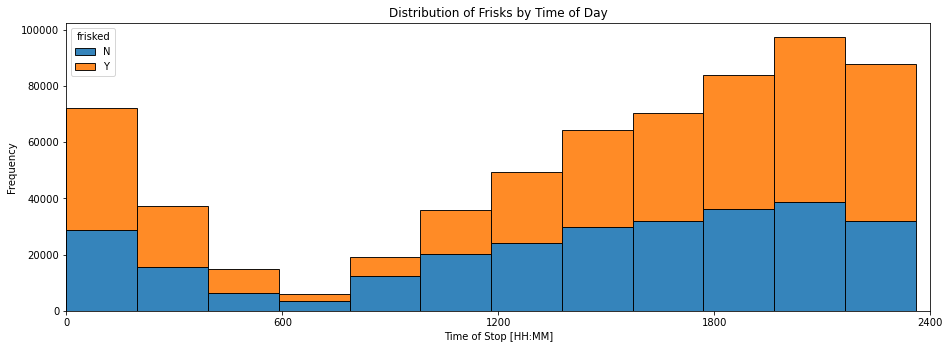

In [34]:
# Visualize distribution of frisks or no frisks by time of day
snf_data_exp.pivot(columns='frisked')['timestop'].plot(kind = 'hist', stacked=True, bins=12,alpha=0.9, edgecolor='black')
plt.xticks(np.arange(0,2500,step=600)); plt.xlim([0,2400])
plt.xlabel('Time of Stop [HH:MM]'); plt.title('Distribution of Frisks by Time of Day')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1, wspace=0.2, hspace=0.2)

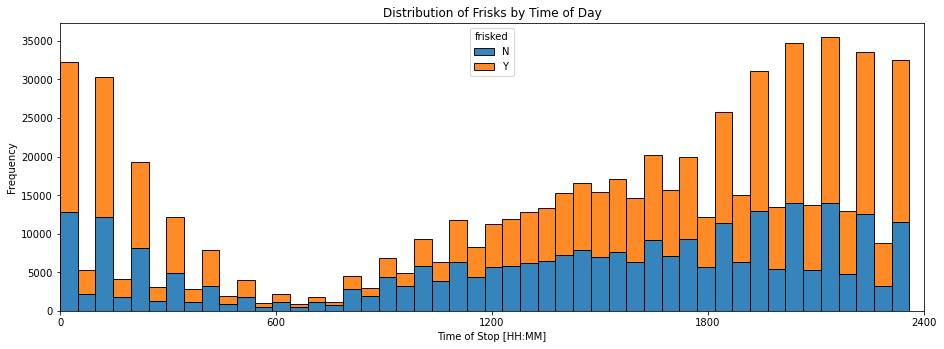

In [35]:
# Visualize distribution of frisks or no frisks by time of day
snf_data_exp.pivot(columns='frisked')['timestop'].plot(kind = 'hist', stacked=True, bins=48, alpha=0.9, edgecolor='black')
plt.xticks(np.arange(0,2500,step=600)); plt.xlim([0,2400])
plt.xlabel('Time of Stop [HH:MM]'); plt.title('Distribution of Frisks by Time of Day')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1, wspace=0.2, hspace=0.2)

Based on the histogram bars, the time of stop has a correlation with the likelihood of being frisked. Binning the time of stop into 12 bins would likely result in loss of information, as compared to 24 bins (but this is too many bins). Hence, I would leave them unbinned for now. It is also important to note that individuals are more likely frisked during the night (& midnight) than the day.

### Explore categorical attributes 

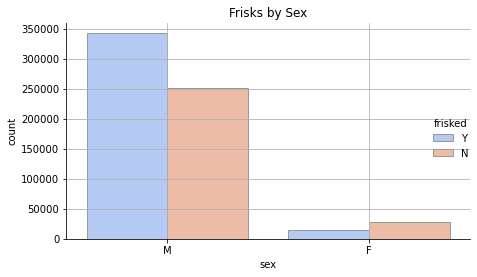

In [36]:
# Visualize frisks by sex
sns.catplot(x='sex', hue='frisked', data=snf_data_exp, kind='count', palette='coolwarm', edgecolor='0.6')
plt.title('Frisks by Sex'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=0.6, wspace=0.01, hspace=0.2)

From the bar chart above, it looks like males (M) are much more likely to be frisked than females (F), by more than 20 times. Women are also less likely to be frisked if stopped by an officer, whereas men are.

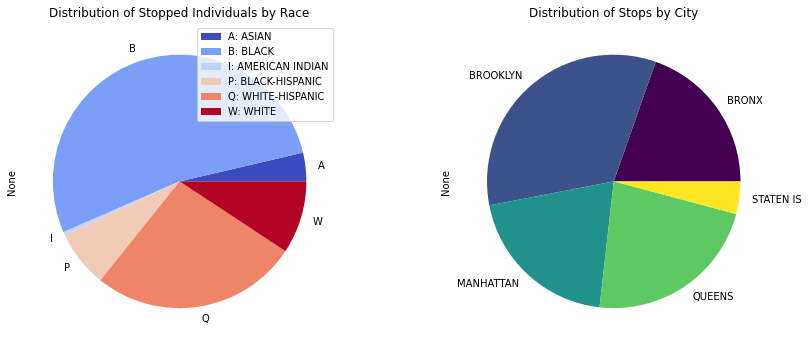

In [37]:
# Visualize distribution of race and city
plt.subplot(121)
snf_data_exp.groupby('race').size().plot.pie(colormap='coolwarm')
plt.legend(labels=('A: ASIAN','B: BLACK','I: AMERICAN INDIAN','P: BLACK-HISPANIC','Q: WHITE-HISPANIC','W: WHITE'))
plt.title('Distribution of Stopped Individuals by Race')

plt.subplot(122)
snf_data_exp.groupby('city').size().plot.pie(colormap='viridis')
plt.title('Distribution of Stops by City')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1.1, wspace=0.01, hspace=0.2)

In 2011, about 50% of individuals stopped by NYPD are black (B) or African American, followed by White-Hispanic (Q), White(W), etc. Most of the police stops occured in the city of Brooklyn (30%) followed by Queens (25%), Manhattan (20%) and Bronx (20%).

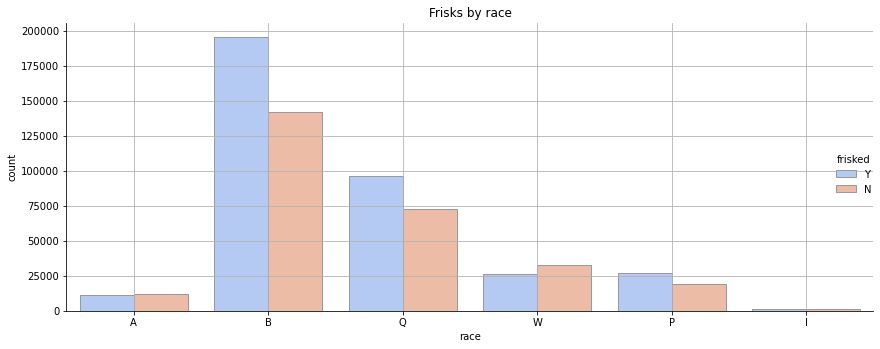

In [38]:
# Visualize frisks by race
sns.catplot(x='race', hue='frisked', data=snf_data_exp, kind='count', palette='coolwarm', edgecolor='0.6')
plt.title('Frisks by race'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.01, hspace=0.2)

Individuals (stopped by police) who are black (B), white-hispanic (Q) and black-hispanic (P) are more likely to be frisked than not, with African-Americans being frisked the most. On the other hand, individuals who are white (W), asian (A) and american indian (I) are less likely to be frisked, with white individuals having the highest no-frisk to frisk ratio.

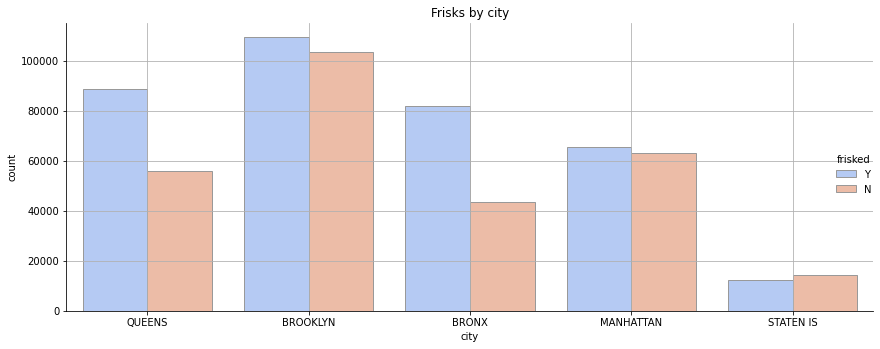

In [39]:
# Visualize frisks by city
sns.catplot(x='city', hue='frisked', data=snf_data_exp, kind='count', palette='coolwarm', edgecolor='0.6')
plt.title('Frisks by city'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.01, hspace=0.2)

It looks like one is more likely to be frisked in most cities (if stopped) except in Staten Island. However, the discrepancy of no-frisk to frisk in Bronx and Queens is the greatest.  

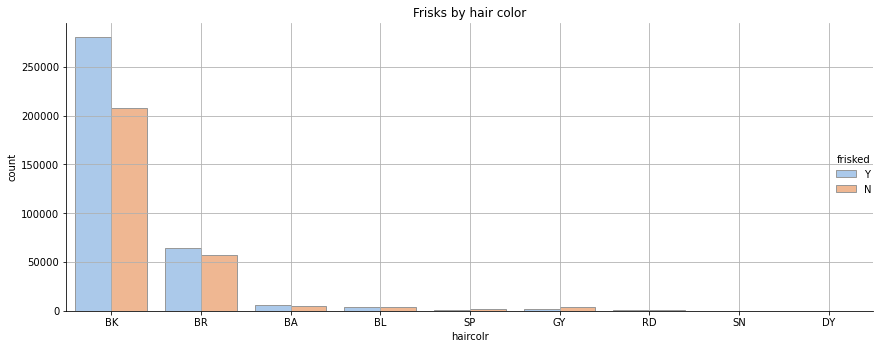

In [40]:
# Visualize frisks by hair color
sns.catplot(x='haircolr', hue='frisked', data=snf_data_exp, kind='count', palette='pastel', edgecolor='0.6')
plt.title('Frisks by hair color'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.01, hspace=0.2)

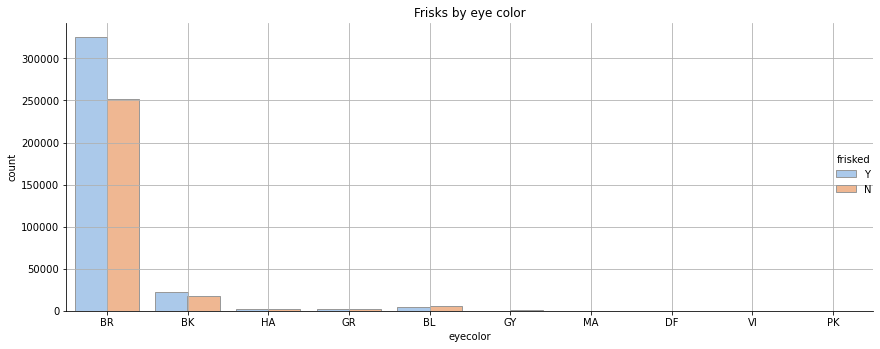

In [41]:
# Visualize frisks by eye color
sns.catplot(x='eyecolor', hue='frisked', data=snf_data_exp, kind='count', palette='pastel', edgecolor='0.6')
plt.title('Frisks by eye color'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.01, hspace=0.2)

Individuals with black hair (BK) and brown eyes (BR) are more likely to be frisked, but given there isn't too much gap between Y/N for all colors of hair and eyes, these attribute don't seem to be signifcant factors in predicting if someone gets frisked.

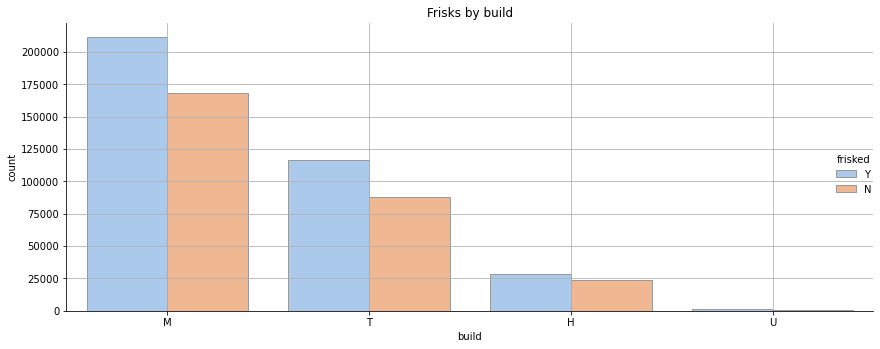

In [42]:
# Visualize frisks by build of body
sns.catplot(x='build', hue='frisked', data=snf_data_exp, kind='count', palette='pastel', edgecolor='0.6')
plt.title('Frisks by build'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.01, hspace=0.2)

Individuals with medium (M) and thin (T) body builds are more likely to be frisked than heavy (H) or muscular (U) builds.

In [43]:
pd.crosstab(columns=snf_data_exp['build'], index=snf_data_exp['frisked'], normalize=True, margins=True)

build,H,M,T,U,All
frisked,,,,,
N,0.037048,0.262836,0.137676,0.001345,0.438906
Y,0.044361,0.331735,0.182848,0.002151,0.561094
All,0.081408,0.594571,0.320525,0.003496,1.000000


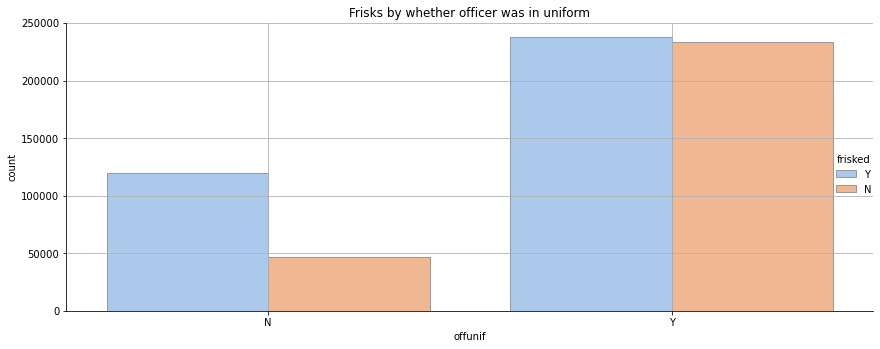

In [44]:
# Visualize frisks by if officer is in uniform
sns.catplot(x='offunif', hue='frisked', data=snf_data_exp, kind='count', palette='pastel', edgecolor='0.6')
plt.title('Frisks by whether officer was in uniform'); plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.01, hspace=0.2)

This chart is interesting as it tells us that an individual is 2.5 times more likely to be frisked if the officer is not in a uniform. On the other hand, there isn't too much difference if the officer is in uniform. This is contradictory to what we would expect.

In [45]:
# Two way table
print("Normalized Two-way Tables for categorical features")
print()
for i in str_cols[6:-1]:
 print(pd.crosstab(columns=snf_data_exp[i], index=snf_data_exp['frisked'], margins=True, normalize=True).iloc[:,:-1])
 print()

Normalized Two-way Tables for categorical features

inout           I         O
frisked                    
N        0.109849  0.329056
Y        0.092752  0.468343
All      0.202601  0.797399

trhsloc         H         P         T
frisked                              
N        0.061047  0.341098  0.036761
Y        0.073953  0.451851  0.035290
All      0.134999  0.792949  0.072051

typeofid         P         R         V
frisked                               
N         0.252849  0.011544  0.174513
Y         0.292749  0.011876  0.256469
All       0.545599  0.023419  0.430982

othpers         N         Y
frisked                    
N        0.351130  0.087775
Y        0.431799  0.129295
All      0.782930  0.217070

explnstp         N         Y
frisked                     
N         0.000409  0.438497
Y         0.000393  0.560701
All       0.000802  0.999198

offunif         N         Y
frisked                    
N        0.073356  0.365550
Y        0.187942  0.373152
All      0.261298  0.

Based on the normalized two-way tables above, we find that: 
* people who identify themselves (typeofid) verbally (V) is more likely to be frisked than if they had presented a photo id (P) or had refused (R). 
* officers who explain their reason for stopping the individual (explnstp) are more likely to frisk them than if they had not explained.
* individuals who display evasive response when questioned (ac_evasv) and change direction at the sight of officer (ac_cgdir) are more likely to be frisked.

## Feature Engineering
Some of the feature engineering like scaling needs to be done in the cross-validation loop, but some of the data may need to be engineered out on a global scale. These include removal of noise from data, conversion of categorical parameters into binary attributes, and sampling of dataset. 

### Remove noise from data (age, height & weight) found in exploration

In [46]:
# Create deep copy of processed dataset
snf_data_feat = snf_data_toclean.copy()
snf_data_feat.shape

(638447, 25)

In [47]:
### Remove erroneous ages, heights and weights

# Remove rows with ages below 5 and above 100 years old 
snf_data_feat = snf_data_feat[(snf_data_feat['age']>=5) & (snf_data_feat['age']<=100)]

# Remove rows with heights below 40 in and above 90 in
snf_data_feat = snf_data_feat[(snf_data_feat['height']>=40) & (snf_data_feat['height']<=90)]

# Remove rows with weights below 50 lbs and above 300 lbs
snf_data_feat = snf_data_feat[(snf_data_feat['weight']>=50) & (snf_data_feat['weight']<=300)]

# Check if some rows were removed correctly 
snf_data_feat[['age','height','weight']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,634006.0,27.872288,11.670406,5.0,19.0,24.0,34.0,100.0
height,634006.0,68.570288,3.116178,40.0,67.0,69.0,71.0,90.0
weight,634006.0,168.677025,28.117731,50.0,150.0,165.0,180.0,300.0


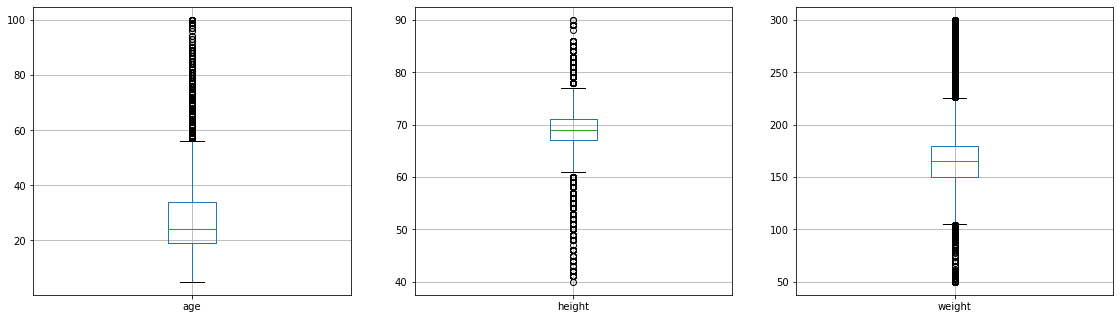

In [48]:
# Visualize distribution of ages, heights and weights
plt.subplot(131)
snf_data_feat.boxplot('age')
plt.subplot(132)
snf_data_feat.boxplot('height')
plt.subplot(133)
snf_data_feat.boxplot('weight')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1, wspace=0.2, hspace=0.2)

Although outliers still exist in these 3 attributes, I believe they're clean enough for us to proceed with analysis. Will consider revisiting if model accuracy needs to be improved.

### Convert categorical values into binary attributes using binarization or One Hot Encoding

This is done to eliminate any ordinal relationship or magnitude differences between nominal categorical data, thus improving model accuracy.

In [49]:
# View number of unique values for each cateogorical parameter
snf_data_feat[str_cols].nunique()

sex          2
race         6
haircolr     9
eyecolor    10
build        4
city         5
inout        2
trhsloc      3
typeofid     3
othpers      2
explnstp     2
offunif      2
ac_rept      2
ac_proxm     2
ac_evasv     2
ac_assoc     2
ac_cgdir     2
ac_incid     2
ac_time      2
ac_stsnd     2
frisked      2
dtype: int64

In [50]:
### sex parameter 
# View unique values for sex parameter
print(snf_data_feat['sex'].value_counts())

# Convert sex parameter into binary
snf_data_feat['sex'] = snf_data_feat['sex'].replace({'M': 1, 'F': 0})

# Check if values converted correctly
print(snf_data_feat['sex'].value_counts())

M    590604
F     43402
Name: sex, dtype: int64
1    590604
0     43402
Name: sex, dtype: int64


In [51]:
### inout parameter
print(snf_data_feat['inout'].value_counts())

# Convert inout parameter into binary
snf_data_feat['inout'] = snf_data_feat['inout'].replace({'I': 1, 'O': 0})

# Check if values converted correctly
print(snf_data_feat['inout'].value_counts())

O    505557
I    128449
Name: inout, dtype: int64
0    505557
1    128449
Name: inout, dtype: int64


In [52]:
# Retrieve list of parameters with yes/no values
yesno_cols = str_cols[snf_data_feat[str_cols].nunique() == 2][2:]
yesno_cols

Index(['othpers', 'explnstp', 'offunif', 'ac_rept', 'ac_proxm', 'ac_evasv',
       'ac_assoc', 'ac_cgdir', 'ac_incid', 'ac_time', 'ac_stsnd', 'frisked'],
      dtype='object')

In [53]:
### Yes/No parameter conversion
# View unique values for different yes/no parameters
snf_data_feat[yesno_cols].apply(pd.value_counts)

,othpers,explnstp,offunif,ac_rept,ac_proxm,ac_evasv,ac_assoc,ac_cgdir,ac_incid,ac_time,ac_stsnd,frisked
N,496311,498,165791,562386,499349,511211,607732,478594,254841,366278,618596,278072
Y,137695,633508,468215,71620,134657,122795,26274,155412,379165,267728,15410,355934


In [54]:
# Convert Yes/No columns to integers (1/0)
snf_data_feat[yesno_cols] = snf_data_feat[yesno_cols].replace({'N':0, 'Y':1})

# Check if values converted correctly
snf_data_feat[yesno_cols].apply(pd.value_counts)

,othpers,explnstp,offunif,ac_rept,ac_proxm,ac_evasv,ac_assoc,ac_cgdir,ac_incid,ac_time,ac_stsnd,frisked
0,496311,498,165791,562386,499349,511211,607732,478594,254841,366278,618596,278072
1,137695,633508,468215,71620,134657,122795,26274,155412,379165,267728,15410,355934


In [55]:
# Retrieve list of parameters with more than 2 values
ohc_cols = str_cols[snf_data_feat[str_cols].nunique() > 2]
ohc_cols

Index(['race', 'haircolr', 'eyecolor', 'build', 'city', 'trhsloc', 'typeofid'], dtype='object')

In [56]:
 # Convert all categorical data into binary using One Hot Encoding
ohc_df = pd.get_dummies(snf_data_feat[ohc_cols])

# Concatenate One Hot Encoding dataframe with original dataframe and the label (frisked) as the last column
snf_data_feat = pd.concat([snf_data_feat.iloc[:,:-1], ohc_df, snf_data_feat.iloc[:,-1]], axis=1)

# Remove columns
snf_data_feat.drop(ohc_cols, axis=1, inplace=True)

snf_data_feat.head()

,sex,age,height,weight,timestop,inout,othpers,explnstp,offunif,ac_rept,...,city_MANHATTAN,city_QUEENS,city_STATEN IS,trhsloc_H,trhsloc_P,trhsloc_T,typeofid_P,typeofid_R,typeofid_V,frisked
0,1,21,68,182,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,1
1,1,15,66,140,5,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,1
2,1,17,67,130,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,1
3,1,17,67,130,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,1
4,1,20,75,185,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,1


In [57]:
# Get list of columns which have binary values
binary_cols = snf_data_feat.columns[5:].insert(loc=0, item=snf_data_feat.columns[0])

# View number of values
snf_data_feat[binary_cols].apply(pd.value_counts)

,sex,inout,othpers,explnstp,offunif,ac_rept,ac_proxm,ac_evasv,ac_assoc,ac_cgdir,...,city_MANHATTAN,city_QUEENS,city_STATEN IS,trhsloc_H,trhsloc_P,trhsloc_T,typeofid_P,typeofid_R,typeofid_V,frisked
0,43402,505557,496311,498,165791,562386,499349,511211,607732,478594,...,506155,489974,607758,548489,131242,588281,287987,619389,360636,278072
1,590604,128449,137695,633508,468215,71620,134657,122795,26274,155412,...,127851,144032,26248,85517,502764,45725,346019,14617,273370,355934


In [58]:
# View distribution in mean and std dev of cleaned dataset
snf_data_feat.describe().iloc[:3]

,sex,age,height,weight,timestop,inout,othpers,explnstp,offunif,ac_rept,...,city_MANHATTAN,city_QUEENS,city_STATEN IS,trhsloc_H,trhsloc_P,trhsloc_T,typeofid_P,typeofid_R,typeofid_V,frisked
count,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,...,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000,634006.000000
mean,0.931543,27.872288,68.570288,168.677025,1438.010790,0.202599,0.217182,0.999215,0.738502,0.112964,...,0.201656,0.227178,0.041400,0.134884,0.792996,0.072121,0.545766,0.023055,0.431179,0.561405
std,0.252528,11.670406,3.116178,28.117731,727.729226,0.401936,0.412328,0.028015,0.439451,0.316549,...,0.401237,0.419009,0.199214,0.341599,0.405159,0.258688,0.497901,0.150078,0.495241,0.496216


### Feature Selection using Random Forest Classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import warnings                           # silence warnings that commonly occur with random forest
warnings.filterwarnings('ignore')

# Create deep copy for feature selection
snf_data_feat_selec = snf_data_feat.copy()

In [60]:
# Perform feature selection using random forest classifier
x = snf_data_feat_selec.iloc[:,:-1]
y = snf_data_feat_selec.iloc[:,-1]

lab_enc = preprocessing.LabelEncoder(); y_encoded = lab_enc.fit_transform(y) # this removes an encoding error 

random_forest_feat = RandomForestClassifier(random_state = 50)   # instantiate the random forest  
random_forest_feat = random_forest_feat.fit(x,np.ravel(y_encoded)) # fit the random forest
importances = random_forest_feat.feature_importances_ # extract the expected feature importances
# std = np.std([tree.feature_importances_ for tree in random_forest_feat.estimators_],axis=0) # calculate stdev over trees
feat_ranks = np.argsort(importances)[::-1]   # find feature ranks in descending order

In [61]:
# Print feature ranking
print("Feature Ranking (The feature importance values sum to 1):")                 
for f in range(x.shape[1]):
    print("%d. %s (%.4f)" % (f + 1, x.columns.values[feat_ranks[f]], importances[feat_ranks[f]]))

Feature Ranking (The feature importance values sum to 1):
1. timestop (0.1977)
2. age (0.1500)
3. weight (0.1292)
4. height (0.1165)
5. offunif (0.0359)
6. ac_incid (0.0238)
7. ac_time (0.0214)
8. othpers (0.0197)
9. ac_proxm (0.0161)
10. ac_evasv (0.0150)
11. ac_cgdir (0.0149)
12. build_M (0.0148)
13. build_T (0.0134)
14. inout (0.0131)
15. ac_rept (0.0129)
16. sex (0.0126)
17. race_B (0.0112)
18. race_Q (0.0105)
19. city_BRONX (0.0100)
20. haircolr_BK (0.0100)
21. city_BROOKLYN (0.0097)
22. haircolr_BR (0.0092)
23. typeofid_V (0.0087)
24. eyecolor_BR (0.0087)
25. typeofid_P (0.0087)
26. city_MANHATTAN (0.0083)
27. city_QUEENS (0.0079)
28. trhsloc_P (0.0077)
29. build_H (0.0076)
30. trhsloc_H (0.0072)
31. ac_assoc (0.0072)
32. eyecolor_BK (0.0072)
33. race_P (0.0069)
34. race_W (0.0068)
35. ac_stsnd (0.0057)
36. trhsloc_T (0.0048)
37. race_A (0.0046)
38. city_STATEN IS (0.0044)
39. typeofid_R (0.0032)
40. haircolr_BA (0.0030)
41. eyecolor_BL (0.0024)
42. haircolr_BL (0.0019)
43. eyeco

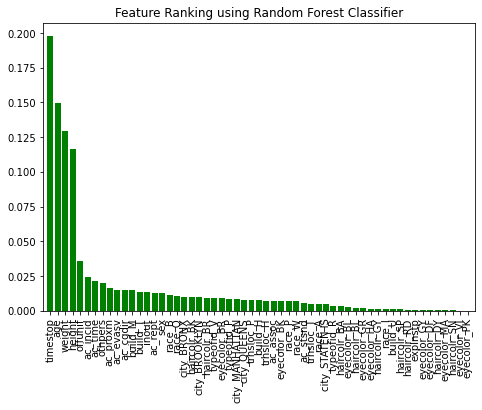

In [62]:
# Plot the feature importance                         
plt.title("Feature Ranking using Random Forest Classifier")
plt.bar(range(x.shape[1]), importances[feat_ranks], color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[feat_ranks], rotation=90)
plt.xlim([-1, x.shape[1]]); plt.ylim(0)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()

We can see that there is a jump in the feature importance score after the 4th-ranked feature. We decided to keep the top 10 features and drop the rest of the features, as these constitute more than 70% of the total feature importances. 

In [63]:
# Create deep copy of dataframe before filtering
snf_data_filtered = snf_data_feat.copy()

In [64]:
snf_data_filtered

,sex,age,height,weight,timestop,inout,othpers,explnstp,offunif,ac_rept,...,city_MANHATTAN,city_QUEENS,city_STATEN IS,trhsloc_H,trhsloc_P,trhsloc_T,typeofid_P,typeofid_R,typeofid_V,frisked
0,1,21,68,182,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,1
1,1,15,66,140,5,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,1
2,1,17,67,130,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,1
3,1,17,67,130,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,1
4,1,20,75,185,7,0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685719,1,22,66,180,2355,0,0,1,1,0,...,0,1,0,0,1,0,1,0,0,1
685720,1,19,69,160,2358,0,0,1,1,0,...,1,0,0,1,0,0,0,0,1,1
685721,1,20,69,200,2358,0,0,1,1,0,...,0,0,0,0,1,0,1,0,0,1
685722,1,22,70,200,2358,0,0,1,1,0,...,0,0,0,0,1,0,1,0,0,1


In [65]:
snf_data_filtered.to_csv("before_task_split.csv",index=False)

In [66]:
first_column = snf_data_filtered.pop('race_B')
snf_data_filtered.insert(0, 'z', first_column)
second_column = snf_data_filtered.pop('frisked')
snf_data_filtered.insert(1, 'y', second_column)

In [67]:
city_MANHATTAN=snf_data_filtered.loc[snf_data_filtered['city_MANHATTAN'] == 1].drop(columns=['city_QUEENS', 'city_MANHATTAN','city_STATEN IS','city_BRONX','city_BROOKLYN'])

In [68]:
city_QUEENS=snf_data_filtered.loc[snf_data_filtered['city_QUEENS'] == 1].drop(columns=['city_QUEENS', 'city_MANHATTAN','city_STATEN IS','city_BRONX','city_BROOKLYN'])
city_STATEN=snf_data_filtered.loc[snf_data_filtered['city_STATEN IS'] == 1].drop(columns=['city_QUEENS', 'city_MANHATTAN','city_STATEN IS','city_BRONX','city_BROOKLYN'])
city_BRONX=snf_data_filtered.loc[snf_data_filtered['city_BRONX'] == 1].drop(columns=['city_QUEENS', 'city_MANHATTAN','city_STATEN IS','city_BRONX','city_BROOKLYN'])
city_BROOKLYN=snf_data_filtered.loc[snf_data_filtered['city_BROOKLYN'] == 1].drop(columns=['city_QUEENS', 'city_MANHATTAN','city_STATEN IS','city_BRONX','city_BROOKLYN'])

In [69]:
city_MANHATTAN.to_csv("city_MANHATTAN.csv",index=False)
city_QUEENS.to_csv("city_QUEENS.csv",index=False)
city_STATEN.to_csv("city_STATEN.csv",index=False)
city_BRONX.to_csv("ccity_BRONX.csv",index=False)
city_BROOKLYN.to_csv("city_BROOKLYN.csv",index=False)

In [70]:
print(city_MANHATTAN['y'].value_counts())

1    65242
0    62609
Name: y, dtype: int64


In [71]:
print(city_QUEENS['y'].value_counts())

1    88498
0    55534
Name: y, dtype: int64


In [72]:
print(city_STATEN['y'].value_counts())

0    14171
1    12077
Name: y, dtype: int64


In [73]:
print(city_BRONX['y'].value_counts())

1    81455
0    43127
Name: y, dtype: int64


In [74]:
print(city_BROOKLYN['y'].value_counts())

1    108662
0    102631
Name: y, dtype: int64


In [75]:
K=10
(14171+12077)/10

2624.8

In [76]:
city = city_MANHATTAN.values

In [77]:
column_name = city_MANHATTAN.columns

In [78]:
column_name

Index(['z', 'y', 'sex', 'age', 'height', 'weight', 'timestop', 'inout',
       'othpers', 'explnstp', 'offunif', 'ac_rept', 'ac_proxm', 'ac_evasv',
       'ac_assoc', 'ac_cgdir', 'ac_incid', 'ac_time', 'ac_stsnd', 'race_A',
       'race_I', 'race_P', 'race_Q', 'race_W', 'haircolr_BA', 'haircolr_BK',
       'haircolr_BL', 'haircolr_BR', 'haircolr_DY', 'haircolr_GY',
       'haircolr_RD', 'haircolr_SN', 'haircolr_SP', 'eyecolor_BK',
       'eyecolor_BL', 'eyecolor_BR', 'eyecolor_DF', 'eyecolor_GR',
       'eyecolor_GY', 'eyecolor_HA', 'eyecolor_MA', 'eyecolor_PK',
       'eyecolor_VI', 'build_H', 'build_M', 'build_T', 'build_U', 'trhsloc_H',
       'trhsloc_P', 'trhsloc_T', 'typeofid_P', 'typeofid_R', 'typeofid_V'],
      dtype='object')

In [79]:
city[0][-1]

1

In [80]:
df = city_MANHATTAN
city = df.values
column_name = df.columns

task=[]
for one in range(1,11):
    index = one-1
    begin = index*2624
    end = (index+1)*2624
    cur=city[begin:end]
    cur_pos=[]
    cur_neg=[]
    for each in cur:
        if(each[-1]==1):
            cur_pos.append(each)
        else:
            cur_neg.append(each)
    df_pos = pd.DataFrame(cur_pos, columns =column_name)
    df_neg = pd.DataFrame(cur_neg, columns =column_name)
    directory='./dataset/task'+str(one)+'/'
    import os
    if not os.path.exists(directory):
        os.makedirs(directory)
    df_pos.to_csv(directory+'task'+str(one)+'_pos.csv')
    df_neg.to_csv(directory+'task'+str(one)+'_neg.csv')



In [81]:
df = city_QUEENS
city = df.values
column_name = df.columns
task=[]
for one in range(11,21):
    index = one-11
    begin = index*2624
    end = (index+1)*2624
    cur=city[begin:end]
    cur_pos=[]
    cur_neg=[]
    for each in cur:
        if(each[-1]==1):
            cur_pos.append(each)
        else:
            cur_neg.append(each)
    df_pos = pd.DataFrame(cur_pos, columns =column_name)
    df_neg = pd.DataFrame(cur_neg, columns =column_name)
    directory='./dataset/task'+str(one)+'/'
    import os
    if not os.path.exists(directory):
        os.makedirs(directory)
    df_pos.to_csv(directory+'task'+str(one)+'_pos.csv')
    df_neg.to_csv(directory+'task'+str(one)+'_neg.csv')
        

In [82]:
df = city_STATEN
city = df.values
column_name = df.columns
task=[]
for one in range(21,31):
    index = one-21
    begin = index*2624
    end = (index+1)*2624
    cur=city[begin:end]
    cur_pos=[]
    cur_neg=[]
    for each in cur:
        if(each[-1]==1):
            cur_pos.append(each)
        else:
            cur_neg.append(each)
    df_pos = pd.DataFrame(cur_pos, columns =column_name)
    df_neg = pd.DataFrame(cur_neg, columns =column_name)
    directory='./dataset/task'+str(one)+'/'
    import os
    if not os.path.exists(directory):
        os.makedirs(directory)
    df_pos.to_csv(directory+'task'+str(one)+'_pos.csv')
    df_neg.to_csv(directory+'task'+str(one)+'_neg.csv')

In [83]:
df = city_BRONX
city = df.values
column_name = df.columns
task=[]
for one in range(31,41):
    index = one-31
    begin = index*2624
    end = (index+1)*2624
    cur=city[begin:end]
    cur_pos=[]
    cur_neg=[]
    for each in cur:
        if(each[-1]==1):
            cur_pos.append(each)
        else:
            cur_neg.append(each)
    df_pos = pd.DataFrame(cur_pos, columns =column_name)
    df_neg = pd.DataFrame(cur_neg, columns =column_name)
    directory='./dataset/task'+str(one)+'/'
    import os
    if not os.path.exists(directory):
        os.makedirs(directory)
    df_pos.to_csv(directory+'task'+str(one)+'_pos.csv')
    df_neg.to_csv(directory+'task'+str(one)+'_neg.csv')

In [84]:
df = city_BROOKLYN
city = df.values
column_name = df.columns
task=[]
for one in range(41,51):
    index = one-41
    begin = index*2624
    end = (index+1)*2624
    cur=city[begin:end]
    cur_pos=[]
    cur_neg=[]
    for each in cur:
        if(each[-1]==1):
            cur_pos.append(each)
        else:
            cur_neg.append(each)
    df_pos = pd.DataFrame(cur_pos, columns =column_name)
    df_neg = pd.DataFrame(cur_neg, columns =column_name)
    directory='./dataset/task'+str(one)+'/'
    import os
    if not os.path.exists(directory):
        os.makedirs(directory)
    df_pos.to_csv(directory+'task'+str(one)+'_pos.csv')
    df_neg.to_csv(directory+'task'+str(one)+'_neg.csv')

### Perform data sampling due to large size of dataset

This is to ensure our models can be run in a reasonable amount of time, given the dataset size of more than 600,000 records. 

In [64]:
# Sample dataset using test train split to keep records that were not sampled 
snf_data_analysis, snf_data_unused = train_test_split(snf_data_filtered, train_size=100000, random_state=100)

# Display shapes of dataset
print("Analysis dataset =",snf_data_analysis.shape)
print("Ununsed dataset =",snf_data_unused.shape)

Analysis dataset = (100000, 58)
Ununsed dataset = (534006, 58)


In [65]:
# Compare % differences in mean and std dev between analysis and full dataset, to ensure representative dataset
analysis_dist = snf_data_analysis.describe().iloc[1:3]
full_dist =  snf_data_filtered.describe().iloc[1:3]
diff_dist = abs(analysis_dist - full_dist)/full_dist * 100   # compute percentage difference
diff_dist

,sex,age,height,weight,timestop,inout,othpers,explnstp,offunif,ac_rept,...,city_MANHATTAN,city_QUEENS,city_STATEN IS,trhsloc_H,trhsloc_P,trhsloc_T,typeofid_P,typeofid_R,typeofid_V,frisked
mean,0.107696,0.148170,0.011124,0.067926,0.161121,0.706307,0.222158,0.001453,0.104600,0.287021,...,0.335136,0.568867,1.691389,0.462311,0.076375,1.704407,0.244404,1.409616,0.233983,0.175492
std,0.676254,0.048711,0.266330,0.057051,0.366295,0.262870,0.079941,0.919637,0.095624,0.124945,...,0.125041,0.200568,0.812676,0.195052,0.108353,0.782204,0.024566,0.690378,0.028100,0.024349


Analysis dataset seems fairly representative of the full dataset - the difference in mean of the response feature (frisked) between the analysis dataset and the complete dataset is less than 0.2%.

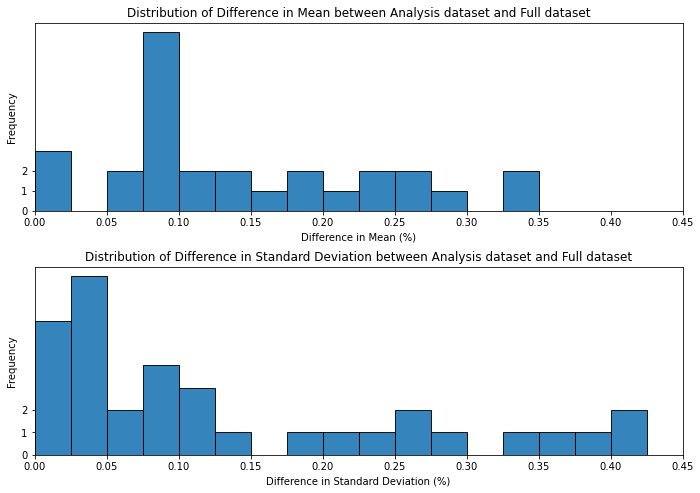

In [66]:
# Visualize % differences in mean and std dev between analysis and full dataset
plt.subplot(211)
diff_dist.loc['mean'].plot(kind='hist', bins=np.arange(0,0.45,0.025), alpha=0.9, edgecolor='black')
# plt.xticks(range(0,36,5)); 
plt.xlim([0,0.45]); plt.yticks([0,1,2])
plt.xlabel('Difference in Mean (%)'); plt.title('Distribution of Difference in Mean between Analysis dataset and Full dataset')
# plt.grid()

plt.subplot(212)
diff_dist.loc['std'].plot(kind='hist', bins=np.arange(0,0.45,0.025), alpha=0.9, edgecolor='black')
# plt.xticks(range(0,36,5)); 
plt.xlim([0,0.45]); plt.yticks([0,1,2])
plt.xlabel('Difference in Standard Deviation (%)'); plt.title('Distribution of Difference in Standard Deviation between Analysis dataset and Full dataset')
# plt.grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.3)

From both these histograms, we can see that the analysis dataset is representative of the full dataset due to low differences in means and standard deviations.

In [67]:
# View analysis dataset
snf_data_analysis.describe().iloc[:3]

,sex,age,height,weight,timestop,inout,othpers,explnstp,offunif,ac_rept,...,city_MANHATTAN,city_QUEENS,city_STATEN IS,trhsloc_H,trhsloc_P,trhsloc_T,typeofid_P,typeofid_R,typeofid_V,frisked
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.930540,27.83099,68.562660,168.562450,1440.327730,0.204030,0.216700,0.999200,0.737730,0.112640,...,0.200980,0.228470,0.040700,0.134260,0.792390,0.073350,0.547100,0.022730,0.430170,0.562390
std,0.254236,11.67609,3.107879,28.133773,725.063588,0.402993,0.411999,0.028273,0.439871,0.316154,...,0.400735,0.419849,0.197595,0.340933,0.405598,0.260711,0.497779,0.149042,0.495102,0.496095


In [68]:
# View unused dataset
snf_data_unused.describe().iloc[:3]

,sex,age,height,weight,timestop,inout,othpers,explnstp,offunif,ac_rept,...,city_MANHATTAN,city_QUEENS,city_STATEN IS,trhsloc_H,trhsloc_P,trhsloc_T,typeofid_P,typeofid_R,typeofid_V,frisked
count,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,...,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000,534006.000000
mean,0.931731,27.880022,68.571716,168.698481,1437.576911,0.202331,0.217273,0.999217,0.738647,0.113025,...,0.201782,0.226936,0.041531,0.135000,0.793109,0.071891,0.545516,0.023116,0.431368,0.561220
std,0.252207,11.669336,3.117731,28.114701,728.227176,0.401738,0.412390,0.027967,0.439372,0.316624,...,0.401331,0.418851,0.199516,0.341724,0.405077,0.258307,0.497924,0.150272,0.495268,0.496238


Moving forward, the analysis dataset (10 predictor features, 1 response feature) will be used for data modelling and analysis. The unused dataset can be used as additional testing data, if necessary.

## Data Analysis

### Method 1

#### SVM

In [69]:
import warnings
warnings.simplefilter('ignore')

#Create a copy of the data to not affect the other methods and split data
snf_data_svm = snf_data_analysis.copy()
snf_data_svm_sample = snf_data_svm.sample(n=10000, random_state=3)
data_Y_svm = snf_data_svm_sample['frisked']
data_X_svm = snf_data_svm_sample.drop('frisked', axis=1)

snf_data_svm_sample.shape

#Create: an object to standardize the features
#        a SVM classifier object
#        a pipeline to train inside of the cross validation loop
scaler_svm = sk.preprocessing.StandardScaler()
svm = SVC()
pipe_svm = Pipeline(steps=[('scaler', scaler_svm), ('svm', svm)])

#Next, we create a grid search to find the best kernel parameters for our data
param_grid_svm = {
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    #'svm__C':list(range(1, 11, 5)),
}
search_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=5)
search_svm.fit(data_X_svm, data_Y_svm)

#We put the parameters found through the grid search into an
#outer cross validation loop to evaluate accuracy of the found parameters on
#unseen data
nested_cv_svm = cross_val_score(search_svm, data_X_svm, data_Y_svm, cv=5)

#Display best parameters and accuracies of crossvalidation
print(search_svm.best_params_)
print("Individual Accuracies:", nested_cv_svm)                                            
print("Average Accuracy:", nested_cv_svm.mean()*100)

# Get predicted classes
pred_Y_svm = cross_val_predict(search_svm, data_X_svm, data_Y_svm, cv=10)

# Print out a matrix and report to assess precision and recall
matrix_svm = confusion_matrix(data_Y_svm, pred_Y_svm)
print(matrix_svm)
report_svm = classification_report(data_Y_svm, pred_Y_svm)
print(report_svm)

{'svm__kernel': 'rbf'}
Individual Accuracies: [0.6355 0.662  0.643  0.6645 0.657 ]
Average Accuracy: 65.24
[[2359 2038]
 [1470 4133]]
              precision    recall  f1-score   support

           0       0.62      0.54      0.57      4397
           1       0.67      0.74      0.70      5603

    accuracy                           0.65     10000
   macro avg       0.64      0.64      0.64     10000
weighted avg       0.65      0.65      0.65     10000



### Interpreting SVM Results

The accuracy for the SVM method is fairly low, around 63%, and the runtime jumps significantly when trying to run a sample size higher than n=10000. This model has trouble mainly due to the number of dimensions involved with the data, which makes finding a hyperplane throught the data computationally intensive.

#### Final SVM Model Stats:  
Accuracy - 61% | Best Kernel - Gaussian radial basis function


### Method 2
#### Naive Bayes

In [70]:
# Using entire dataset
snf_data_mlp = snf_data_filtered.copy()

# Separate labels from the features
data_Y = snf_data_mlp['frisked']
data_X = snf_data_mlp.drop('frisked', axis=1)

# Create Naive Bayes classifier
clf = GaussianNB()

# Fit the model on the data
clf = clf.fit(data_X, data_Y)

# Cross validate to get accuracy
scores = cross_val_score(clf, data_X, data_Y, cv=10)
accuracy = scores.mean()
print(accuracy)

0.6049642507305536


In [71]:
# Get predicted classes
pred_Y = cross_val_predict(clf, data_X, data_Y, cv=10)

# Print out a matrix and report to assess precision and recall
matrix = confusion_matrix(data_Y, pred_Y)
print(matrix)
report = classification_report(data_Y, pred_Y)
print(report)

[[ 91784 186288]
 [ 64167 291767]]
              precision    recall  f1-score   support

           0       0.59      0.33      0.42    278072
           1       0.61      0.82      0.70    355934

    accuracy                           0.60    634006
   macro avg       0.60      0.57      0.56    634006
weighted avg       0.60      0.60      0.58    634006



### Interpreting Naive Bayes Results

The accuracy for the Naive Bayes classifier is slightly lower than the other two classifiers used at about 60%. It's not a good enough accuracy to be considered a good predictor of whether someone will be frisked or not; however, considering the relatively similar accuracy values to the other methods used, the runtime of naive bayes on this dataset was significantly faster. However, this method can not be further improved by tuning hyperparameters, so it will not get any better while the other two methods have the potential for better accuracies with more tuning and more data to feasibly train on.

The confusion matrix reveals that the model is slightly more precise and has a slightly higher f1-score for someone who gets frisked, which is likley the result of a class imbalance (+77,862 records for class 1) and likely should be ignored for that reason.

#### Final Naive Bayes Model Stats:  
Final accuracy: 60.28%

### Method 3
#### KNN

In [72]:
# Define a pipeline to search for the best combination of 
# PCA dimensions and n_neighbors.
from sklearn.model_selection import GridSearchCV

snf_data_knn = snf_data_analysis.copy()

#Separate label and drop label from data
data_Y = snf_data_knn['frisked']
data_X = snf_data_knn.drop('frisked', axis=1)

#crate a scaler
scaler = sk.preprocessing.MinMaxScaler()

#create a PCA
pca = PCA()

#create a KNN classifier
knn = KNeighborsClassifier()

#create a pipeline that does scaling, then PCA, then KNN
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knn', knn)])

#Set up the parameters you want to tune for each of your pipeline steps
#Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': list(range(1, 20)), #find how many principal componenet to keep
    'knn__n_neighbors': list(range(1, 30)),  #find the best value of k
    'knn__weights': ['uniform', 'distance'], #find if weighting points equally (uniform) or with weights (distance) is better
}

GridCLF_pipe = GridSearchCV(pipe, param_grid, cv=5)
GridCLF_pipe.fit(data_X, data_Y)
print(GridCLF_pipe.best_score_)
print(GridCLF_pipe.best_params_)

0.63059
{'knn__n_neighbors': 29, 'knn__weights': 'uniform', 'pca__n_components': 16}


### Interpreting KNN Results

The accuracy for a KNN test with a pipeline selecting the best parameters is about 60.8%. This is not ideal for predicting whether or not someone will be frisked based on various features of their situation or physical characteristics. With further tuning of the hyperparameters, particularly the k value, this could definitely be improved.

#### Final KNN Model Stats:  
Parameters: Accuracy - 60.8% | N Neighbors - 29 | Weights - Uniform | N Components in PCA - 9

## Conclusion

Looking at the results of our models, the best model produced was the SVM model at 61% accuracy, however all 3 models produced similar results in terms of accuracy. None of the models were accurate enough to consistently predict whether someone would get frisked or not. This due to a number of factors, but ultimately the limitation on number of records that could be feasibly trained on with the compute power available kept the models from being as accurate as they could be. With further tuning of the hyperparameters and more compute time to handle training more of the dataset, the accuracy could be improved.